In [1]:
# Load data & basic parsing helpers
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt

CSV_PATH = r"C:\Users\Vex\Desktop\football\dataset\matchday\clean_matchday_stat.csv"
df = pd.read_csv(CSV_PATH)

# Resolve common header variants
aliases = {
    "home_team": ["home_team","HomeTeam","home","Home","Home Team","home_side"],
    "away_team": ["away_team","AwayTeam","away","Away","Away Team","away_side"],
    "home_score": ["home_score","FTHG","HomeGoals","home_final_goal","home_fulltime_goals"],
    "away_score": ["away_score","FTAG","AwayGoals","away_final_goal","away_fulltime_goals"],
}
resolved = {}
for k, opts in aliases.items():
    for c in opts:
        if c in df.columns:
            resolved[k] = c
            break

HOME = resolved.get("home_team")
AWAY = resolved.get("away_team")
FTHG = resolved.get("home_score")
FTAG = resolved.get("away_score")
if not all([HOME, AWAY, FTHG, FTAG]):
    raise ValueError(f"Missing basic columns. Resolved so far: {resolved}")

# Locate goal-minute columns by name pattern (prefers home/away + goal + time)
def find_goal_time_cols(columns):
    cols = list(columns)
    def pick(side):
        cand = [c for c in cols if side in c.lower() and "goal" in c.lower() and "time" in c.lower()]
        return cand[0] if cand else None
    gh = pick("home")
    ga = pick("away")
    if gh is None:
        cand = [c for c in cols if "goal" in c.lower() and "time" in c.lower()]
        gh = cand[0] if cand else None
    if ga is None:
        cand = [c for c in cols if "goal" in c.lower() and "time" in c.lower() and c != gh]
        ga = cand[0] if cand else None
    return gh, ga

GOAL_H_COL, GOAL_A_COL = find_goal_time_cols(df.columns)
if not GOAL_H_COL or not GOAL_A_COL:
    raise ValueError(f"Could not locate goal-minute columns. Found: home={GOAL_H_COL}, away={GOAL_A_COL}")

print("Resolved columns:", {"HOME": HOME, "AWAY": AWAY, "FTHG": FTHG, "FTAG": FTAG,
                           "GOAL_H_COL": GOAL_H_COL, "GOAL_A_COL": GOAL_A_COL})

# Parse list-like goal strings to integer minutes (stoppage capped at 90)
minute_re = re.compile(r"^\s*(\d+)(?:\+(\d+))?\s*'?" )

def parse_listlike(s):
    """Return a list from strings like "['7\\'', '45+2\\'']" or "7', 45+2'". """
    if pd.isna(s):
        return []
    if isinstance(s, (list, tuple)):
        return list(s)
    s = str(s).strip()
    if s == "" or s.lower() in {"na","nan","none","[]"}:
        return []
    if s.startswith("[") and s.endswith("]"):
        try:
            out = ast.literal_eval(s)
            if isinstance(out, (list, tuple)):
                return list(out)
        except Exception:
            pass
    return [t.strip() for t in s.split(",") if t.strip()]

def to_minute(token, cap=90):
    """Convert tokens like 45+2', 90+5, 7' → int minute; cap for state accounting."""
    if token is None:
        return None
    m = minute_re.match(str(token))
    if not m:
        return None
    base = int(m.group(1)); add = int(m.group(2) or 0)
    return min(base + add, cap)

def parse_goal_minutes(cell):
    """Parse a cell to sorted integer goal minutes."""
    toks = parse_listlike(cell)
    out = [to_minute(t) for t in toks]
    return sorted([m for m in out if m is not None])

# Quick sanity preview
for col in [GOAL_H_COL, GOAL_A_COL]:
    sample = df[col].dropna().astype(str).head(3).tolist()
    print(f"Sample {col}:", sample)
    print("Parsed:", [parse_goal_minutes(x) for x in sample])


Resolved columns: {'HOME': 'home_team', 'AWAY': 'away_team', 'FTHG': 'home_score', 'FTAG': 'away_score', 'GOAL_H_COL': 'home_team_goals_current_time', 'GOAL_A_COL': 'away_team_goals_current_time'}
Sample home_team_goals_current_time: ['["12\'", "27\'"]', '["30\'", "38\'", "72\'", "88\'"]', '["60\'", "77\'"]']
Parsed: [[12, 27], [30, 38, 72, 88], [60, 77]]
Sample away_team_goals_current_time: ['["62\'"]', '["42\'", "46\'"]', '["64\'"]']
Parsed: [[62], [42, 46], [64]]


In [2]:
# Reconstruct game state per match and aggregate per team
MATCH_DURATION = 90  # minutes used for state accounting

def game_state_minutes(home_goal_mins, away_goal_mins, duration=MATCH_DURATION):
    """Return (lead, draw, behind) minutes from the HOME perspective."""
    events = []
    for t in home_goal_mins: events.append((t, +1))
    for t in away_goal_mins: events.append((t, -1))
    events.sort(key=lambda x: x[0])

    lead = draw = behind = 0.0
    prev_t = 0
    score_diff = 0  # home - away

    for (t, delta) in events:
        t = min(int(t), duration)
        if t > prev_t:
            span = t - prev_t
            if score_diff > 0:   lead += span
            elif score_diff == 0: draw += span
            else:                behind += span
            prev_t = t
        score_diff += delta
        if prev_t >= duration:
            break

    if prev_t < duration:
        span = duration - prev_t
        if score_diff > 0:   lead += span
        elif score_diff == 0: draw += span
        else:                behind += span

    return int(lead), int(draw), int(behind)

# Per-match table
rows = []
for i, r in df.iterrows():
    hg = parse_goal_minutes(r[GOAL_H_COL])
    ag = parse_goal_minutes(r[GOAL_A_COL])
    lead, draw, behind = game_state_minutes(hg, ag, MATCH_DURATION)
    rows.append({
        "match_id": i,
        "home_team": r[HOME],
        "away_team": r[AWAY],
        "home_lead_min": lead,
        "home_draw_min": draw,
        "home_behind_min": behind,
        "away_lead_min": behind,   # mirror of home
        "away_draw_min": draw,
        "away_behind_min": lead,
    })
match_states = pd.DataFrame(rows)

# Aggregate to team level
home_agg = (match_states
            .groupby("home_team", as_index=False)[["home_lead_min","home_draw_min","home_behind_min"]]
            .sum()
            .rename(columns={"home_team":"team",
                             "home_lead_min":"lead_min",
                             "home_draw_min":"draw_min",
                             "home_behind_min":"behind_min"}))

away_agg = (match_states
            .groupby("away_team", as_index=False)[["away_lead_min","away_draw_min","away_behind_min"]]
            .sum()
            .rename(columns={"away_team":"team",
                             "away_lead_min":"lead_min",
                             "away_draw_min":"draw_min",
                             "away_behind_min":"behind_min"}))

team_state = (pd.concat([home_agg, away_agg], ignore_index=True)
              .groupby("team", as_index=False)[["lead_min","draw_min","behind_min"]].sum())

# Add percentages relative to minutes played
matches_played = (pd.concat([
                    df[[HOME]].rename(columns={HOME:"team"}),
                    df[[AWAY]].rename(columns={AWAY:"team"})
                  ])
                  .value_counts("team")
                  .rename_axis("team")
                  .reset_index(name="matches"))
team_state = team_state.merge(matches_played, on="team", how="left")
team_state["total_min"] = team_state["matches"] * MATCH_DURATION
for c in ["lead_min","draw_min","behind_min"]:
    team_state[c + "_pct"] = 100 * team_state[c] / team_state["total_min"]

team_state = team_state.sort_values("lead_min_pct", ascending=False).reset_index(drop=True)
print(team_state.head(10).to_string(index=False))


               team  lead_min  draw_min  behind_min  matches  total_min  lead_min_pct  draw_min_pct  behind_min_pct
   Bayer Leverkusen      1519      1285         256       34       3060     49.640523     41.993464        8.366013
      Bayern Munich      1491      1112         457       34       3060     48.725490     36.339869       14.934641
          Stuttgart      1395      1204         461       34       3060     45.588235     39.346405       15.065359
         RB Leipzig      1283      1397         380       34       3060     41.928105     45.653595       12.418301
           Dortmund      1186      1352         522       34       3060     38.758170     44.183007       17.058824
         Hoffenheim       988      1204         868       34       3060     32.287582     39.346405       28.366013
          Wolfsburg       829      1288         943       34       3060     27.091503     42.091503       30.816993
 B. Monchengladbach       800      1307         953       34       3060 

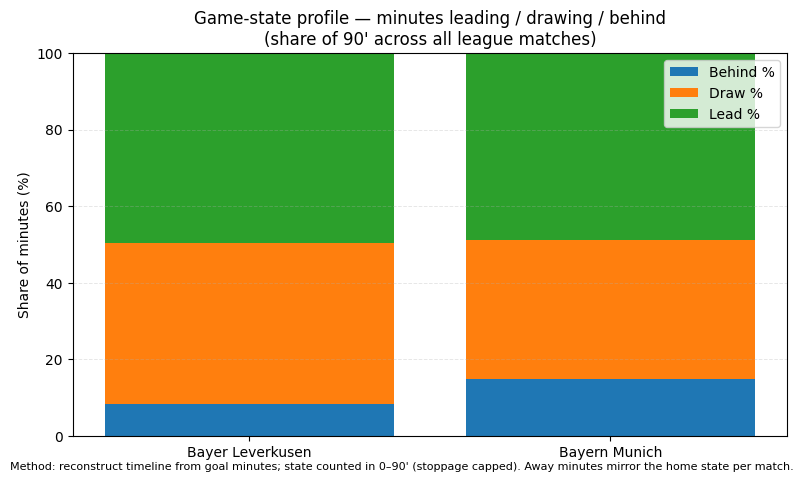

In [3]:
# Compare game-state shares for Leverkusen vs Bayern
def find_team(needle):
    m = team_state[team_state["team"].str.contains(needle, case=False, na=False)]
    return m.iloc[0] if not m.empty else None

lev = find_team("Leverkusen")
bay = find_team("Bayern")

subset = pd.DataFrame([
    {"team": lev["team"], "Lead %": lev["lead_min_pct"], "Draw %": lev["draw_min_pct"], "Behind %": lev["behind_min_pct"]},
    {"team": bay["team"], "Lead %": bay["lead_min_pct"], "Draw %": bay["draw_min_pct"], "Behind %": bay["behind_min_pct"]},
])

fig, ax = plt.subplots(figsize=(8, 4.8))
bottom = np.zeros(len(subset))
for part in ["Behind %", "Draw %", "Lead %"]:  # stack from negative → positive feel
    ax.bar(subset["team"], subset[part], bottom=bottom, label=part)
    bottom += subset[part].to_numpy(float)

ax.set_ylabel("Share of minutes (%)")
ax.set_title("Game-state profile — minutes leading / drawing / behind\n(share of 90' across all league matches)")
ax.legend(loc="upper right")
ax.set_ylim(0, 100)
ax.grid(True, axis="y", alpha=0.3, linestyle="--", linewidth=0.7)

fig.text(0.01, 0.01,
         "Method: reconstruct timeline from goal minutes; state counted in 0–90' (stoppage capped). "
         "Away minutes mirror the home state per match.",
         fontsize=8)

plt.tight_layout()
plt.show()
